In [4]:
import re

import pandas as pd
import torch
import os
import json
import numpy as np
import pickle
from pingouin import ttest, anova, kruskal, rm_anova, ancova
import tikzplotlib as tikz

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style()

In [5]:
def save_plot(path, name, fig):
    with open(path + "tikz/" + name + ".pkl", 'wb') as file:
        pickle.dump(fig, file)
    fig.savefig(path + "svg/" + name + ".svg")

In [6]:
parent_path = "../neurips/"
plot_path = "../neurips/plots/"
run = ''
approach = "abstractbeam"

In [7]:
with open(parent_path + f"{approach}/models{run}/model-best-valid.ckpt", "rb") as f:
    ckpt = torch.load(f)  # , map_location=torch.device("mps"))

In [8]:
inventions = ckpt["inventions"]
for inv in inventions:
    print(inv.name, inv.program, inv.arity)

fn_0 Count((lambda v1: Less(v1, x1)), x2) 2
fn_1 x1(Min(Add(1, 1), x2)) 2
fn_3 Add(-1, x1) 1
fn_5 Count((lambda v1: Equal(v1, x1)), x2) 2
fn_6 x1(Min(fn_3(1), x2)) 2
fn_8 x1(Min(0, x2)) 2
fn_14 x1(0, x2) 2


In [9]:
constants = ckpt["domain"].constants
print(f"initial constants: {[-1, 1]}")
print(f"now: {constants}")

initial constants: [-1, 1]
now: [-1, 1, 0]


In [10]:
with open(parent_path + f"{approach}/results{run}/run_1.json", "rb") as json_file:
    results = json.load(json_file)
solutions = [ele for ele in results["results"] if ele["success"]]
len(solutions) / len(results["results"]) * 100

44.0

54.00000214576721 57.999998331069946


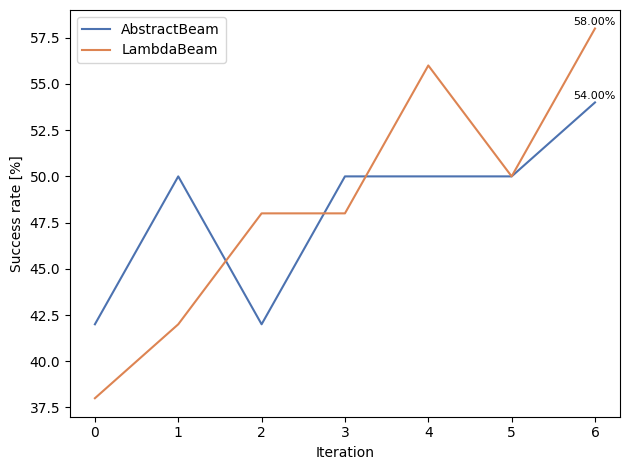

In [40]:
path_dict = {"abstractbeam fold 1": ["events.out.tfevents.1714053475.dws-07.3890530.0", "events.out.tfevents.1714032509.dws-07.3771435.0"],
             "abstractbeam fold 2": ["events.out.tfevents.1714457794.dws-08.391667.0"],
             "lambdabeam fold 1 og": ["events.out.tfevents.1714976185.dws-04.1910039.0"],
             "abstractbeam fold 1 og": ["events.out.tfevents.1714975955.dws-08.865485.0"],
             "lambdabeam fold 1": ["events.out.tfevents.1713428257.dws-06.1874500.0", "events.out.tfevents.1713532162.dws-06.528186.0"],
             "lambdabeam fold 2": ["events.out.tfevents.1714628885.dws-06.876364.0"]}
# Path to your event file or directory
ab_file = f'../neurips/abstractbeam/models2/logs/'
scalars_AB, times = [], []
for file in path_dict["abstractbeam fold 2"]: 
    # Initialize an event accumulator
    event_AB = EventAccumulator(ab_file + file)
    event_AB.Reload()
    scalars = event_AB.Scalars('eval/succ')
    times += [ele.wall_time for ele in scalars]
    scalars_AB += [ele.value for ele in scalars]

inds = np.argsort(times)
scalars_AB = np.array(scalars_AB)[inds] 

lb_file = parent_path + f'lambdabeam/models2/logs/'
scalars_LB, times = [], []
for file in path_dict["lambdabeam fold 2"]: 
    # Initialize an event accumulator
    event_LB = EventAccumulator(lb_file + file)
    event_LB.Reload()
    scalars = event_LB.Scalars('eval/succ')
    times += [ele.wall_time for ele in scalars]
    scalars_LB += [ele.value for ele in scalars]

max_len = max(len(scalars_AB), len(scalars_LB))
fig, ax = plt.subplots()
df = pd.DataFrame.from_dict({"AbstractBeam": np.array(list(scalars_AB) + [np.nan] * (max_len - len(scalars_AB))) * 100, "LambdaBeam": np.array(list(scalars_LB) + [np.nan] * (max_len - len(scalars_LB))) * 100})
sns.lineplot(df, x=np.arange(len(df)), y=df["AbstractBeam"], label="AbstractBeam")
ax.text(len(scalars_AB) - 0.75, max(df["AbstractBeam"])+0.1, f'{max(df["AbstractBeam"]):.2f}%', ha='right', va='bottom', fontsize=8)
sns.lineplot(df, x=np.arange(len(df)), y=df["LambdaBeam"], label="LambdaBeam")
ax.text(len(scalars_LB) - 0.75, max(df["LambdaBeam"])+0.1, f'{max(df["LambdaBeam"]):.2f}%', ha='right', va='bottom', fontsize=8)
ax.set_ylabel("Success rate [%]")
ax.set_xlabel("Iteration")
# fig.legend()
fig.tight_layout()
# save_plot(plot_path, "performance_iteration_fold1_og", plt.gcf())
print(max(df["AbstractBeam"]), max(df["LambdaBeam"]))

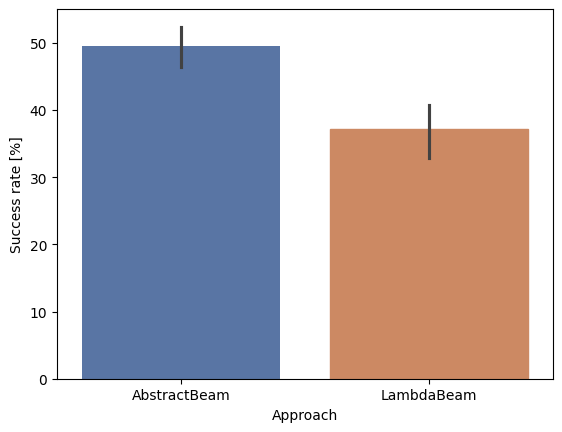

In [12]:
path = "../neurips/abstractbeam/eval/handwritten/"
succ_ab = []
for e, file_path in enumerate(os.listdir(path)):
    with open(path + file_path) as f:
        results = json.load(f)["num_tasks_solved"]
    succ_ab.append(results / 50 * 100)

sns.set_palette("deep")
path = "../neurips/lambdabeam/eval/handwritten/"
succ_lb = []
for e, file_path in enumerate(os.listdir(path)):
    with open(path + file_path) as f:
        results = json.load(f)["num_tasks_solved"]
    succ_ab.append(results / 50 * 100)
    
df = pd.DataFrame.from_dict(
    {"Success rate [%]": succ_ab + succ_lb, "Approach": ["AbstractBeam"] * 5 + ["LambdaBeam"] * 5})
ax = sns.barplot(df, x="Approach", y="Success rate [%]")
ax.patches[1].set_color(sns.color_palette(desat=0.75)[1])
# save_plot(plot_path, "performance_fold1", plt.gcf())

In [20]:
from crossbeam.data.deepcoder.solution_weight import solution_weight
def load_and_process_results(file_paths, path, key="elapsed_time"):
    l = []
    for e, file_path in enumerate(file_paths):
        with open(path + file_path) as f:
            results = json.load(f)["results"]
        if key == "total_num_values_explored":
            num_programs, success = zip(*[(sol["stats"][key], sol["success"]) for sol in results if sol["stats"]["total_num_values_explored"] and sol["elapsed_time"] <= 100])
        elif key == "elapsed_time":
            num_programs, success = zip(*[(sol["elapsed_time"], sol["success"]) for sol in results if sol["elapsed_time"] and sol["elapsed_time"] <= 100])
        elif key == "Solution weight":
            num_programs, success = zip(*[(solution_weight(sol["solution"], domain=ckpt["domain"]), sol["success"]) for sol in results if sol["elapsed_time"] and sol["elapsed_time"] <= 100])
            
        sorted_data = sorted(zip(num_programs, success))
        sorted_time_taken, sorted_tasks_solved = zip(*sorted_data)
        cumulative_tasks = [sum(sorted_tasks_solved[:i+1]) / len(results) * 100 for i in range(len(sorted_tasks_solved))]
        if key == "elapsed_time":
            sorted_time_taken = list(sorted_time_taken) + [100]
            cumulative_tasks.append(cumulative_tasks[-1])
            x_key = "Elapsed time"
        elif key == "total_num_values_explored":
            sorted_time_taken = list(sorted_time_taken)
            x_key = "Number of explored values"
        elif key == "Solution weight":
            sorted_time_taken = list(sorted_time_taken)
            x_key = key
        
        l.append(pd.DataFrame.from_dict({x_key: sorted_time_taken, "Success rate [%]": cumulative_tasks}))
    if key == "Solution weight":
        return pd.concat(l).sort_values(x_key)
    dfs = pd.concat(l).sort_values(x_key)
    dfs[x_key] = dfs[x_key].rolling(window=3).mean()
    dfs = dfs.drop_duplicates(subset=[x_key])
    dfs = dfs.set_index(x_key)
    dfs['Success rate [%]'] = dfs['Success rate [%]'].rolling(window=3).mean()
    dfs['Moving Max'] = dfs['Success rate [%]'].rolling(window=3).max()
    dfs['Moving Min'] = dfs['Success rate [%]'].rolling(window=3).min()
    return dfs


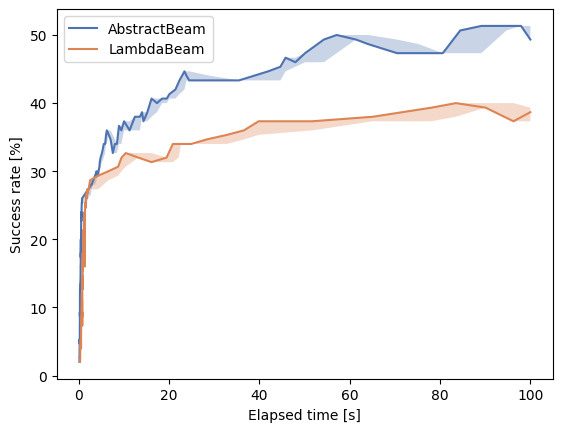

In [22]:
ax = plt.subplot()
df_ab = load_and_process_results(os.listdir("../neurips/abstractbeam/eval/handwritten/"), "../neurips/abstractbeam/eval/handwritten/")
df_lb = load_and_process_results(os.listdir("../neurips/lambdabeam/eval/handwritten/"), "../neurips/lambdabeam/eval/handwritten/")

sns.lineplot(df_ab, x="Elapsed time", y="Success rate [%]", label="AbstractBeam", ax=ax)
plt.fill_between(df_ab.index, df_ab["Moving Min"], df_ab["Moving Max"], alpha=0.3)

sns.lineplot(df_lb, x="Elapsed time", y="Success rate [%]", label="LambdaBeam", ax=ax)
ax.set_xlabel("Elapsed time [s]")
plt.fill_between(df_lb.index, df_lb["Moving Min"], df_lb["Moving Max"], alpha=0.3)
#save_plot(plot_path, "performance_time_fold1", plt.gcf())

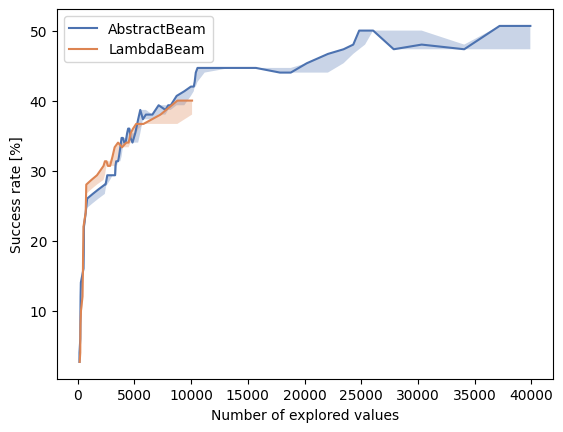

In [23]:
ax = plt.subplot()
df_ab = load_and_process_results(os.listdir("../neurips/abstractbeam/eval/handwritten/"), "../neurips/abstractbeam/eval/handwritten/", key="total_num_values_explored")
df_lb = load_and_process_results(os.listdir("../neurips/lambdabeam/eval/handwritten/"), "../neurips/lambdabeam/eval/handwritten/", key="total_num_values_explored")

sns.lineplot(df_ab, x="Number of explored values", y="Success rate [%]", label="AbstractBeam", ax=ax)
plt.fill_between(df_ab.index, df_ab["Moving Min"], df_ab["Moving Max"], alpha=0.3)
sns.lineplot(df_lb, x="Number of explored values", y="Success rate [%]", label="LambdaBeam", ax=ax)
plt.fill_between(df_lb.index, df_lb["Moving Min"], df_lb["Moving Max"], alpha=0.3)
# save_plot(plot_path + "performance_programs", plt.gcf())

In [24]:
def process_data_over_length(file_paths, path, key="Success rate [%]"):
    
    df = {"Solution weight": [], key: []}
    for e, file_path in enumerate(file_paths):
        with open(path + file_path) as f:
            results = json.load(f)["results"]

        if key == "Success rate [%]":
            success = np.array([sol["success"] if sol["success"] else False for sol in results])
            x_axis = [solution_weight(sol["task_solution"], domain=ckpt["domain"]) for sol in results]
            df["Solution weight"] += x_axis
            df["Success rate [%]"] += list(success)
        elif key == "Abstraction usage [%]":
            sols = [sol for sol in results if sol["solution"]] 
            abs_used = np.array([True if "fn_" in str(sol["solution"]) else False for sol in sols])
            x_axis = [solution_weight(sol["task_solution"], domain=ckpt["domain"]) for sol in sols]
            df["Solution weight"] += x_axis
            df["Abstraction usage [%]"] += list(abs_used)
        elif key == "Elapsed time [s]":
            success = np.array([sol["elapsed_time"] for sol in results]) 
            x_axis = [solution_weight(sol["task_solution"], domain=ckpt["domain"]) for sol in results]
            df["Solution weight"] += x_axis
            df["Elapsed time [s]"] += list(success)
        elif key == "Average number of used abstractions":
            success = np.array([str(sol["solution"]).count("fn_") for sol in results if sol["solution"]])
            x_axis = [solution_weight(sol["task_solution"], domain=ckpt["domain"]) for sol in results if sol["solution"]]
            df["Solution weight"] += x_axis
            df["Average number of used abstractions"] += list(success)

    dfs = pd.DataFrame.from_dict(df)
    return dfs

(-0.5, 7.5)

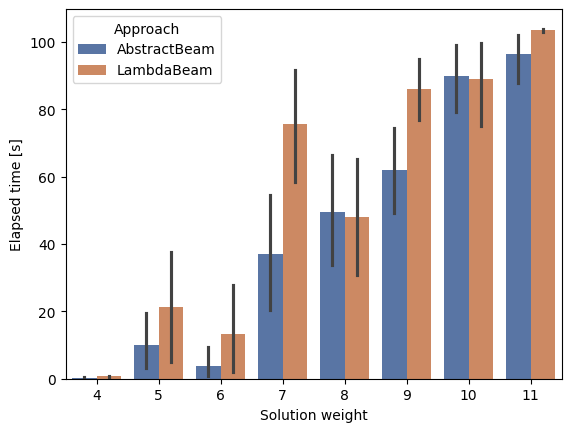

In [25]:
key = "Elapsed time [s]"
bined_df_ab = process_data_over_length(os.listdir("../neurips/abstractbeam/eval/handwritten/"), "../neurips/abstractbeam/eval/handwritten/", key=key)
bined_df_lb = process_data_over_length(os.listdir("../neurips/lambdabeam/eval/handwritten/"), "../neurips/lambdabeam/eval/handwritten/", key=key)
df_merged = pd.concat([bined_df_ab, bined_df_lb], keys=['AbstractBeam', 'LambdaBeam']).reset_index()
df_merged.drop(columns="level_1", inplace=True)
df_merged.rename(columns={'level_0': 'Approach'}, inplace=True)

ax = plt.subplot()
sns.barplot(df_merged, x="Solution weight", y=key, hue="Approach", ax=ax, errorbar="ci")
plt.xlim(-0.5, 7.5)
# save_plot(plot_path, "performance_programlength", plt.gcf())

In [39]:
path = "../neurips/abstractbeam/eval/handwritten/results4.json"
program_lengths = {i: [] for i in range(4, 20)}
with open(path ) as f:
    results = json.load(f)["results"]
for res in results:
    program_lengths[solution_weight(res["task_solution"], domain=ckpt["domain"])].append(res["elapsed_time"])
print([f"{l}: {np.array(t).mean()}" for l, t in program_lengths.items()])
path = "../neurips/lambdabeam/eval/handwritten/results4.json"
program_lengths = {i: [] for i in range(4, 20)}

with open(path) as f:
    results = json.load(f)["results"]
for res in results:
    program_lengths[solution_weight(res["task_solution"], domain=ckpt["domain"])].append(res["elapsed_time"])
print([f"{l}: {np.array(t).mean()}" for l, t in program_lengths.items()])

['4: 0.33466627534168464', '5: 6.691606820002198', '6: 1.0030115572735667', '7: 35.64424044499174', '8: 54.92257840479724', '9: 59.545564386900516', '10: 84.1626352498075', '11: 101.70985004438553', '12: 101.61376267721062', '13: 101.59995786391664', '14: 101.46813831792679', '15: 101.48805322509725', '16: nan', '17: nan', '18: nan', '19: 101.46791446290445']
['4: 0.6400426916467646', '5: 21.043600478372536', '6: 6.294982959749177', '7: 82.68615010599606', '8: 30.125453434791417', '9: 86.27529464311665', '10: 85.40917438140605', '11: 102.92360256416723', '12: 102.35816105725826', '13: 102.69214035302866', '14: 102.5514220809564', '15: 102.60708458907902', '16: nan', '17: nan', '18: nan', '19: 102.81042375892866']


/tmp/ipykernel_1071483/1804506192.py:7: RuntimeWarning: Mean of empty slice.
  print([f"{l}: {np.array(t).mean()}" for l, t in program_lengths.items()])
/tmp/ipykernel_1071483/1804506192.py:15: RuntimeWarning: Mean of empty slice.
  print([f"{l}: {np.array(t).mean()}" for l, t in program_lengths.items()])


In [2]:
bined_df_ab = process_data_over_length(os.listdir("../neurips/abstractbeam/eval/handwritten/"), "../neurips/abstractbeam/eval/handwritten/", key="Abstraction usage [%]")

ax = plt.subplot()
sns.barplot(bined_df_ab, x="Solution weight", y="Abstraction usage [%]", ax=ax)
# save_plot(plot_path, "abstraction_usage", plt.gcf())

NameError: name 'process_data_over_length' is not defined

In [3]:
bined_df_ab = process_data_over_length(os.listdir("../neurips/abstractbeam/eval/handwritten/"), "../neurips/abstractbeam/eval/handwritten/", "Average number of used abstractions")

ax = plt.subplot()
sns.barplot(bined_df_ab, x="Solution weight", y="Average number of used abstractions", ax=ax)
# save_plot(plot_path + "abstractionusage_programlength", plt.gcf())

NameError: name 'process_data_over_length' is not defined

In [ ]:
[(inv.name, inv.program) for inv in ckpt["inventions"]] + [('0', '0')]

In [ ]:
sols = [sol["solution"] for sol in solutions if sol["solution"] and "fn_" in str(sol["solution"]) or "0" in str(sol["solution"])]
invs = [inv.name for inv in ckpt["inventions"]] + ['0']
count = {inv: 0 for inv in invs}
for inv in invs:
    for sol in sols:
        if str(inv) in str(sol):
            count[inv] += 1
count  

In [ ]:
path = "../neurips/abstractbeam/results/run_1.json"
with open(path) as f:
    results_ab = json.load(f)["results"]

path = "../neurips/lambdabeam/results/run_1.json"
with open(path) as f:
    results_lb = json.load(f)["results"]

for i in range(len(results_ab)):
    if results_ab[i]["success"] and not results_lb[i]["success"]:
        print(f"AbstractBeam solved: {results_ab[i]['solution']}, {results_ab[i]['task_solution']}")
        matches = re.findall('fn_\d+|0', results_ab[i]['solution'])
        if len(matches) > 0:
            print(rf"used abstraction(s): {matches}")
    if not results_ab[i]["success"] and results_lb[i]["success"]:
        print(f"LambdaBeam solved: {results_lb[i]['solution']}, {results_lb[i]['task_solution']}")